# 🏁 02 – Podium Prediction Model

This notebook builds a machine learning model to predict whether a Formula 1 driver will finish on the podium (Top 3) using historical race data.

We'll load, clean, and merge multiple datasets, engineer predictive features, train several classifiers, and analyze performance.


In [38]:
# Import libraries for data handling, plotting, modeling
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Set a consistent style for plots
sns.set(style="whitegrid")

# Define data path
DATA_PATH = "../data/Formula_1/"

# Load core datasets
races = pd.read_csv(DATA_PATH + "races.csv")
results = pd.read_csv(DATA_PATH + "results.csv")
drivers = pd.read_csv(DATA_PATH + "drivers.csv")
constructors = pd.read_csv(DATA_PATH + "constructors.csv")
qualifying = pd.read_csv(DATA_PATH + "qualifying.csv")
driver_standings = pd.read_csv(DATA_PATH + "driver_standings.csv")
constructor_standings = pd.read_csv(DATA_PATH + "constructor_standings.csv")




📦 Load Libraries & Data

In [39]:
# Import libraries for data handling, plotting, modeling
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Set a consistent style for plots
sns.set(style="whitegrid")

# Define data path
DATA_PATH = "../data/Formula_1/"

# Load core datasets
races = pd.read_csv(DATA_PATH + "races.csv")
results = pd.read_csv(DATA_PATH + "results.csv")
drivers = pd.read_csv(DATA_PATH + "drivers.csv")
constructors = pd.read_csv(DATA_PATH + "constructors.csv")
qualifying = pd.read_csv(DATA_PATH + "qualifying.csv")
driver_standings = pd.read_csv(DATA_PATH + "driver_standings.csv")
constructor_standings = pd.read_csv(DATA_PATH + "constructor_standings.csv")



🎯 Define Target Variable

In [40]:
# Create a binary target: 1 = podium (Top 3), 0 = not podium
results["podium"] = results["positionOrder"].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# View distribution of classes (note: imbalanced problem)
results["podium"].value_counts(normalize=True)



podium
0    0.873052
1    0.126948
Name: proportion, dtype: float64

🔗 Merge Datasets

In [41]:
# Merge races (to get year, circuit, date)
merged = results.merge(races[["raceId", "year", "circuitId", "date"]], on="raceId", how="left")

# Merge drivers (for driver info)
merged = merged.merge(drivers[["driverId", "driverRef", "nationality"]], on="driverId", how="left")

# Merge constructors (for team name)
merged = merged.merge(constructors[["constructorId", "name"]], on="constructorId", how="left")
merged = merged.rename(columns={"name": "constructor_name"})



➕ Add Feature: Qualifying Position

In [42]:
# Use best qualifying position per driver per race
qualifying_min = qualifying.groupby(["raceId", "driverId"])[["position"]].min().reset_index()
qualifying_min = qualifying_min.rename(columns={"position": "qualifying_position"})

# Merge it in
merged = merged.merge(qualifying_min, on=["raceId", "driverId"], how="left")


➕ Add Feature: Driver Points

In [43]:
# Use latest available points for driver in that race
driver_points = driver_standings.groupby(["raceId", "driverId"])[["points"]].max().reset_index()
driver_points = driver_points.rename(columns={"points": "driver_points"})

merged = merged.merge(driver_points, on=["raceId", "driverId"], how="left")


➕ Add Feature: Constructor Points

In [44]:
# Use latest available points for constructor in that race
constructor_points = constructor_standings.groupby(["raceId", "constructorId"])[["points"]].max().reset_index()
constructor_points = constructor_points.rename(columns={"points": "constructor_points"})

merged = merged.merge(constructor_points, on=["raceId", "constructorId"], how="left")



🧼 Select & Encode Features

In [45]:
# Choose useful features for modeling
model_data = merged[[
    "grid",
    "qualifying_position",
    "driver_points",
    "constructor_points",
    "constructor_name",
    "driverRef",
    "year",
    "podium"
]].dropna()

# One-hot encode categorical variables
model_data_encoded = pd.get_dummies(
    model_data,
    columns=["constructor_name", "driverRef", "year"],
    drop_first=True
)



🔀 Train/Test Split

In [46]:
# Split into features and target
X = model_data_encoded.drop("podium", axis=1)
y = model_data_encoded["podium"]

# 80/20 train-test split with stratification for class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



🤖 Train 3 Models

In [47]:
from sklearn.preprocessing import StandardScaler

# Scale the data only for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest (no scaling)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Logistic Regression (scaled)
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# XGBoost (no need for label encoder anymore)
xgb = XGBClassifier(eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)




📊 Compare Models

C:\Users\Mantas\AppData\Local\Temp\ipykernel_68240\2199444282.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Mantas\anaconda3\envs\portfolio_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


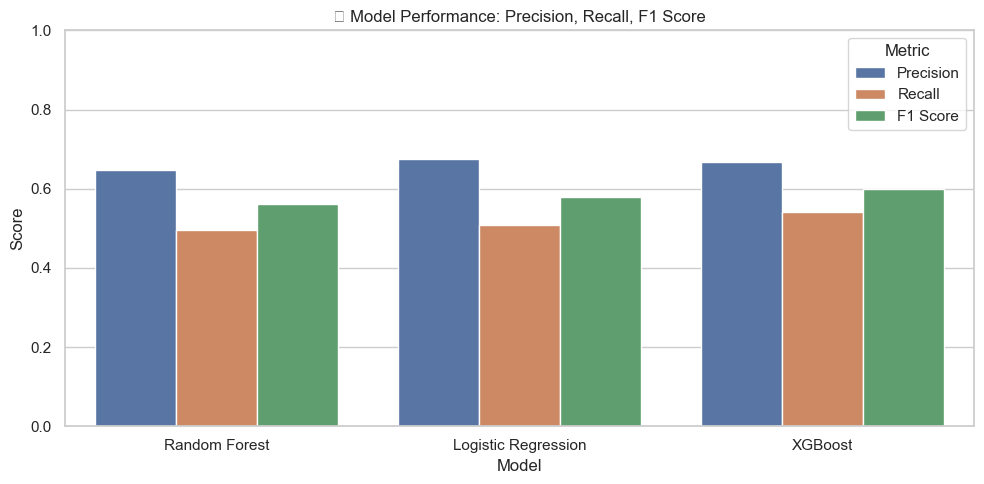

In [48]:
# Collect metrics
scores = [
    {"Model": "Random Forest", "Precision": precision_score(y_test, y_pred_rf), "Recall": recall_score(y_test, y_pred_rf), "F1 Score": f1_score(y_test, y_pred_rf)},
    {"Model": "Logistic Regression", "Precision": precision_score(y_test, y_pred_lr), "Recall": recall_score(y_test, y_pred_lr), "F1 Score": f1_score(y_test, y_pred_lr)},
    {"Model": "XGBoost", "Precision": precision_score(y_test, y_pred_xgb), "Recall": recall_score(y_test, y_pred_xgb), "F1 Score": f1_score(y_test, y_pred_xgb)},
]

score_df = pd.DataFrame(scores)
score_df_melted = score_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=score_df_melted, x="Model", y="Score", hue="Metric")
plt.title("📊 Model Performance: Precision, Recall, F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



🔍 XGBoost Feature Importance

C:\Users\Mantas\AppData\Local\Temp\ipykernel_68240\1253825648.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df.head(20), x="Importance", y="Feature", palette="crest")
C:\Users\Mantas\AppData\Local\Temp\ipykernel_68240\1253825648.py:13: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Mantas\anaconda3\envs\portfolio_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


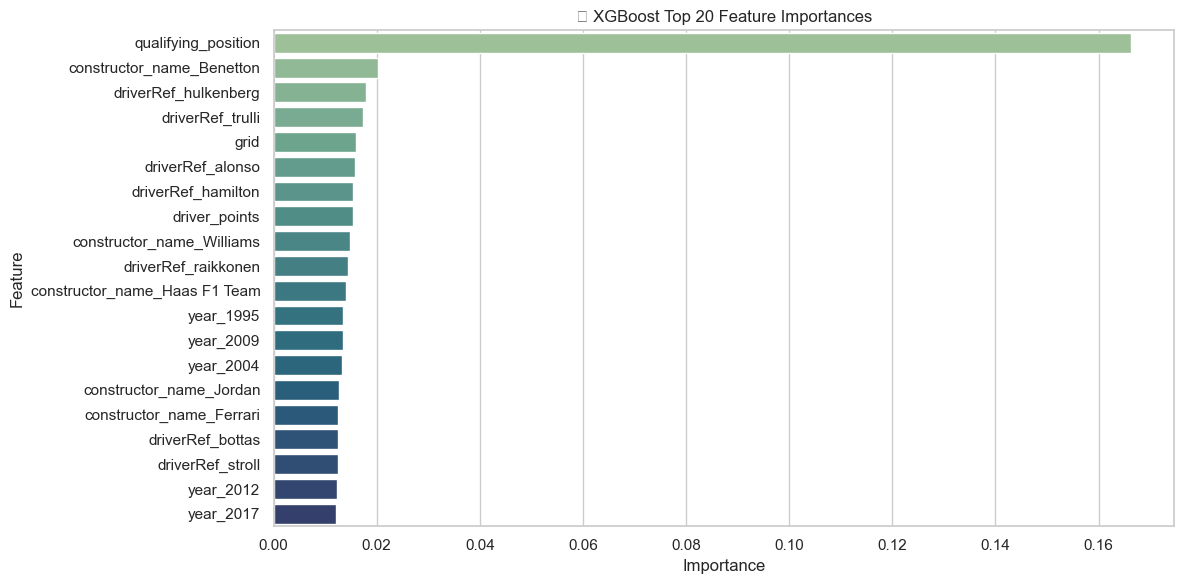

In [49]:
# Visualize XGBoost's top 20 feature importances
xgb_importances = xgb.feature_importances_
feature_names = X.columns

feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": xgb_importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feat_df.head(20), x="Importance", y="Feature", palette="crest")
plt.title("🔥 XGBoost Top 20 Feature Importances")
plt.tight_layout()
plt.show()


🔁 Bonus: Compare Feature Importance Between Model

C:\Users\Mantas\AppData\Local\Temp\ipykernel_68240\289387690.py:16: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Mantas\anaconda3\envs\portfolio_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


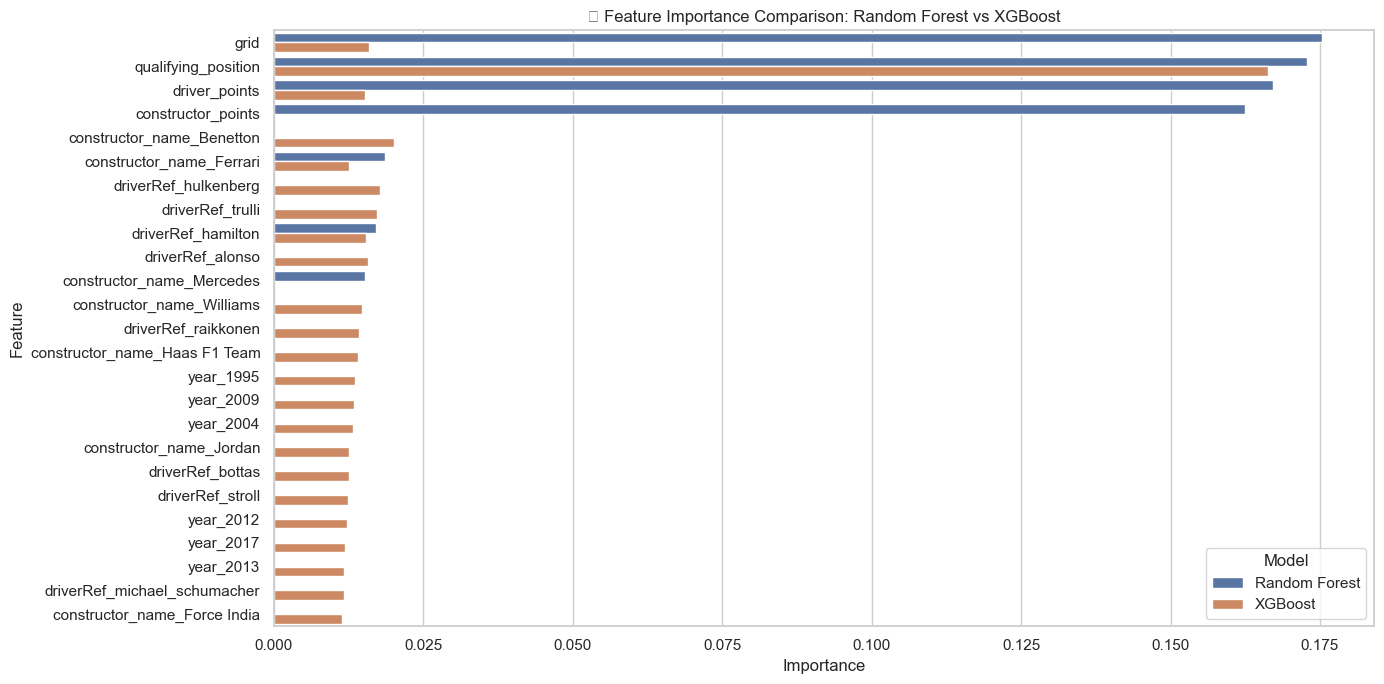

In [50]:
# Random Forest
rf_importances = rf.feature_importances_

# Compare side-by-side
feat_compare = pd.DataFrame({
    "Feature": feature_names,
    "Random Forest": rf_importances,
    "XGBoost": xgb_importances
})

feat_compare_melted = feat_compare.melt(id_vars="Feature", var_name="Model", value_name="Importance")

plt.figure(figsize=(14, 7))
sns.barplot(data=feat_compare_melted.sort_values(by="Importance", ascending=False).head(30), x="Importance", y="Feature", hue="Model")
plt.title("🔍 Feature Importance Comparison: Random Forest vs XGBoost")
plt.tight_layout()
plt.show()
